In [164]:
import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import numpy as np
from sklearn import preprocessing
import pickle
from sklearn.model_selection import StratifiedShuffleSplit

In [165]:
with open('song_df_aggregate.pkl', 'rb') as f:
        song_df= pickle.load(f)  

In [166]:
song_df["top10"] = song_df["bestrank"] <50

In [167]:
to_pop =["artist","title","isnew","rank","date","spotify_id","spotify_explicit",
             "spotify_album_id","spotify_album_release_date","spotify_album_release_date_precision","album_label",
             "join","spotify_album_release_date_datetime","firstrank","numberofappearances","spotify_disc_number"]
#"spotify_mode","spotify_time_signature","num_artists","artist_has_award","gold_count","platinum_count","spotify_track_number"
[song_df.pop(i) for i in to_pop]
song_df.pop("last_award_type")
song_df.pop("spotify_key")
song_df.pop("bestrank")

0         1
1         2
2         1
3         1
4         1
       ... 
8514     79
8515     93
8516     95
8517     99
8518    100
Name: bestrank, Length: 8519, dtype: int64

In [168]:
song_df.pop("artist_has_award")
song_df = song_df.dropna()
top10 = song_df.pop("top10")


In [169]:
X_train, X_test, y_train, y_test = train_test_split(song_df, top10, test_size=0.2)

In [170]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
#lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)


#can replace 'is_unbalance': 'true', by 'scale_pos_weight': 10,

parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'boosting': 'gbdt',
    'is_unbalance': 'true',
    'num_leaves': 25,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

model = lgb.train(parameters,
                       lgb_train,
                       valid_sets=lgb_train,
                       num_boost_round=100,
                       early_stopping_rounds=100)

predictions = model.predict(X_test)


[1]	training's auc: 0.58209
Training until validation scores don't improve for 100 rounds
[2]	training's auc: 0.615208
[3]	training's auc: 0.637543
[4]	training's auc: 0.64278
[5]	training's auc: 0.652743
[6]	training's auc: 0.653834
[7]	training's auc: 0.657703
[8]	training's auc: 0.662104
[9]	training's auc: 0.663745
[10]	training's auc: 0.672948
[11]	training's auc: 0.674834
[12]	training's auc: 0.678173
[13]	training's auc: 0.682189
[14]	training's auc: 0.684083
[15]	training's auc: 0.689101
[16]	training's auc: 0.694293
[17]	training's auc: 0.694679
[18]	training's auc: 0.697316
[19]	training's auc: 0.699226
[20]	training's auc: 0.701037
[21]	training's auc: 0.703258
[22]	training's auc: 0.705316
[23]	training's auc: 0.708834
[24]	training's auc: 0.712705
[25]	training's auc: 0.713991
[26]	training's auc: 0.714794
[27]	training's auc: 0.71566
[28]	training's auc: 0.718564
[29]	training's auc: 0.721057
[30]	training's auc: 0.723183
[31]	training's auc: 0.724247
[32]	training's auc:

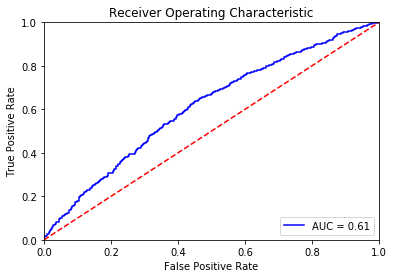

In [171]:
import sklearn.metrics as metrics

fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
%matplotlib inline
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [172]:
# Record the feature importances
feature_importances = model.feature_importance()
for i in range(len(feature_importances)):
    print(feature_importances[i],X_train.columns[i])

218 spotify_duration_ms
83 spotify_track_number
233 spotify_danceability
186 spotify_energy
119 spotify_loudness
21 spotify_mode
217 spotify_speechiness
236 spotify_acousticness
113 spotify_instrumentalness
191 spotify_liveness
167 spotify_valence
221 spotify_tempo
16 spotify_time_signature
15 num_artists
112 award_num
81 gold_count
102 platinum_count
69 num_songs_awards


In [173]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/Users/iliasmiraoui/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [174]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.56


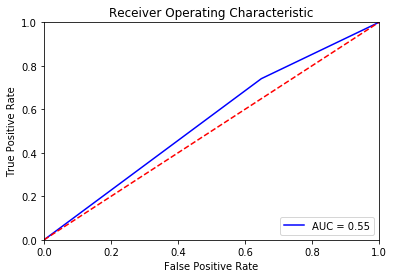

In [175]:
import sklearn.metrics as metrics

fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
%matplotlib inline
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [176]:
from sklearn.metrics import confusion_matrix

predictions_matrix = [1 if pred > 0.5 else 0 for pred in predictions]
confusion_matrix(y_test,predictions_matrix)

array([[450, 339],
       [340, 525]])